# project 2

## set up

### step 0

In [12]:
# step 0
# I use macbook. I have created a folder for this project, then I create a virtal environment for 
# the python code.
# If you also use Macbook, here is the command I have used
# cd /path/to/your_project
# python3 -m venv .venv
# source .venv/bin/activate

### step 1

In [ ]:
# step 1: upgrade pip, skip this step if you already upgraded pip
# pip install --upgrade pip

### step 2

In [ ]:
# step 2: install relevant packages, kip this step if you already have insatlled them
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install scikit-image

## my solution

### import packages

In [43]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [58]:
# global variables which is speicfied in the task description
learning_rate = 0.5
n0 = 28 # input dimention
n1 = 64 # hidden layer 1
n2 = 32 # hidden layer 2
n3 = 3  # output dimention

### load data

In [ ]:
# 1. Load MNIST digits
digits = load_digits()
X = digits.data               # shape: (543, 64)
y = digits.target             # shape: (543,)

# 2. Filter classes (1,5,7)
# if the entity in y is 1, 5, or y, then the value true will be stored
# in the mask.
# otherwise, it will store False.
mask = np.isin(y, [1, 5, 7])
X = X[mask]
y = y[mask]

# map labels to {0,1,2}
# label_map is an dictionary,
# previously, the entity in the y represents classes, its value is 0,1,...9
# we only concern about classes 1,5,7,
# therefore, we do mapping on them
label_map = {1:0, 5:1, 7:2}
y = np.array([label_map[v] for v in y])

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Standardize
# standardize formular: z = (x - u)/sigma
# u: mean, sigma:
# here, scaler is an empty object, it has no idea about
# how data looks like
scaler = StandardScaler()
# fit_transform does 2 tasks:
# 1) fit: calculate the mean u and std sigma of each colum
# 2) transform: apply the standardize formular(z = (x - u)/sigma)
# on each element of the matrix
X_train = scaler.fit_transform(X_train)

# here, we should only use transform, because the test data set can not
# use its own mean and std, it should use the u and sigma of the training
# data set
X_test = scaler.transform(X_test)

### utility functions

In [39]:
# the task description:
# one_hot encoding, mit Ausgabe eines Binären 3-dimensionalen Arrays,
# wie habe y samples, K categories
# each row means to which category does the sample belong to
def one_hot(y, K=3):
    N = len(y)
    Y = np.zeros((N, K))
    Y[np.arange(N), y] = 1
    return Y

def test_one_hot():
    # Test
    # the example below shows how is the input and output 
    # when you use one_hot function
    y = np.array([2,1,0,2])
    Y = np.zeros((4,3))
    print(Y)
    result = one_hot(y)
    print(result)
    """     [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]

            [[0. 0. 1.]
            [0. 1. 0.]
            [1. 0. 0.]
            [0. 0. 1.]]
    """

In [40]:
# how I got this formula, 
# please read the softplus function herleiten.jpg, that is my note
def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

# derivative of log(1+exp(x)) = derivative(1+exp(x)) * (1/(1+exp(x)))
def d_softplus(x):
    return 1 / (1 + np.exp(-x))   # sigmoid

In [41]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# concrete steps of proof/calculating
# please read the derivative of sigmoid herleiten.jpg. that is my note
def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

In [ ]:
# the dimention of z is : (N,K)
# because the task gives: we use the one-hot encoded labels
# the output of a one-hot encoed is (N，K)
def softmax(z):
    # first, substract the maximum item of each row,
    # For numerical stability, compute softmax on logits sby subtracting the row-wise maximum
    # rowwise substraction, hence, axis = 1
    z_shifted = z - np.max(z,axis=1,keepdims=True)

    # then, we want to calculate the exponentional value of each item
    exp_z = np.exp(z_shifted)
    # sum up the exponential value
    sum_exp_z = np.sum(exp_z,axis=1,keepdims=True)
    # each item divide itself by sum-up value, it gives possibility
    probabilities = exp_z / sum_exp_z
    return probabilities

def cross_entropy_loss(logits, Y):
    N = logits.shape[0]
    softmax_Y = softmax(Y)
    # add eps, in case that some possibiliy is 0
    # log(0) is not allowed
    eps = 1e-12
    loss = -np.sum(Y* np.log(softmax_Y + eps)) / N
    gradient_logits = (softmax_Y - Y) / N
    return loss, gradient_logits

def mse_loss(logits,Y):
    N = logits.shape[0]
    loss = 0.5 * np.sum((logits - Y)**2) / N
    gradient_logits = (logits - Y)/N
    return loss, gradient_logits



### build up multilayer perceptron (MLP)

In [59]:
# ---------- MLP 网络定义 ----------

class MLP:
    def __init__(self, D, n1=64, n2=32, K=3, seed=0):
        rng = np.random.default_rng(seed)

        # W 的 shape: (输入维度, 输出维度)
        self.W1 = rng.normal(0, learning_rate, size=(D, n1))
        self.b1 = np.zeros((1, n1))

        self.W2 = rng.normal(0, learning_rate, size=(n1, n2))
        self.b2 = np.zeros((1, n2))

        self.W3 = rng.normal(0, learning_rate, size=(n2, K))
        self.b3 = np.zeros((1, K))

    def forward(self, X):
        """
        X: (N, D)
        返回 (logits, cache)
        logits: (N, K) = z3
        cache: 反向传播需要用到的中间量
        """
        a0 = X                              # 输入层

        z1 = a0 @ self.W1 + self.b1        # (N, n1)
        a1 = softplus(z1)                  # softplus 激活

        z2 = a1 @ self.W2 + self.b2        # (N, n2)
        a2 = softplus(z2)

        z3 = a2 @ self.W3 + self.b3        # (N, K)，输出层不加激活（identity）

        logits = z3

        cache = {
            "a0": a0,
            "z1": z1, "a1": a1,
            "z2": z2, "a2": a2,
            "z3": z3
        }
        return logits, cache

    def backward(self, grad_logits, cache):
        """
        使用反向传播计算所有参数的梯度。

        grad_logits: dL/dz3, shape (N, K)
        cache: forward 保存的中间量
        返回: 一个 dict，里面是 dW1, db1, dW2, db2, dW3, db3
        """
        a0 = cache["a0"]
        z1, a1 = cache["z1"], cache["a1"]
        z2, a2 = cache["z2"], cache["a2"]
        z3 = cache["z3"]

        # ---------- 输出层 W3, b3 ----------
        # z3 = a2 @ W3 + b3
        dW3 = a2.T @ grad_logits                # (n2, N) @ (N, K) -> (n2, K)
        db3 = np.sum(grad_logits, axis=0, keepdims=True)  # (1, K)

        # ---------- 反传到第二层 ----------
        # 先得到 dL/da2 = dL/dz3 @ W3^T
        da2 = grad_logits @ self.W3.T          # (N, K) @ (K, n2) -> (N, n2)
        # z2 经过 softplus，导数是 sigmoid(z2)
        dz2 = da2 * d_softplus(z2)             # (N, n2)

        dW2 = a1.T @ dz2                       # (n1, N) @ (N, n2) -> (n1, n2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # ---------- 反传到第一层 ----------
        da1 = dz2 @ self.W2.T                  # (N, n2) @ (n2, n1) -> (N, n1)
        dz1 = da1 * d_softplus(z1)             # (N, n1)

        dW1 = a0.T @ dz1                       # (D, N) @ (N, n1) -> (D, n1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        grads = {
            "dW1": dW1, "db1": db1,
            "dW2": dW2, "db2": db2,
            "dW3": dW3, "db3": db3
        }
        return grads

    def step(self, grads, lr):
        """
        用梯度下降更新参数
        """
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]

        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]

        self.W3 -= lr * grads["dW3"]
        self.b3 -= lr * grads["db3"]

    def predict(self, X):
        """
        返回预测的类别标签（0,1,2）
        """
        logits, _ = self.forward(X)
        y_pred = np.argmax(logits, axis=1)
        return y_pred


### training the model

In [60]:
# ---------- 全批量梯度下降训练 ----------

def train_full_batch(
    X_train, y_train,
    X_test, y_test,
    n_epochs=100,
    lr=0.1,
    loss_type="mse",
    seed=0
):
    """
    loss_type: "mse" 或 "ce" (cross-entropy)
    返回: (mlp, history)
      mlp: 训练好的网络
      history: 字典，里面记录了每个 epoch 的 loss 和 accuracy
    """
    D = X_train.shape[1]
    K = 3  # 类别数

    # one-hot 标签
    Y_train = one_hot(y_train, K=K)
    Y_test = one_hot(y_test, K=K)

    mlp = MLP(D=D, n1=64, n2=32, K=K, seed=seed)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(1, n_epochs + 1):
        # ---- 前向：训练集 ----
        logits_train, cache_train = mlp.forward(X_train)

        if loss_type == "mse":
            loss_train, grad_logits = mse_loss(logits_train, Y_train)
        elif loss_type == "ce":
            loss_train, grad_logits = cross_entropy_loss(logits_train, Y_train)
        else:
            raise ValueError("loss_type must be 'mse' or 'ce'")

        # ---- 反向传播 + 更新参数 ----
        grads = mlp.backward(grad_logits, cache_train)
        mlp.step(grads, lr)

        # ---- 计算 train accuracy ----
        y_pred_train = np.argmax(logits_train, axis=1)
        acc_train = accuracy_score(y_train, y_pred_train)

        # ---- 在 test 上评估 ----
        logits_test, _ = mlp.forward(X_test)
        if loss_type == "mse":
            loss_test, _ = mse_loss(logits_test, Y_test)
        else:
            loss_test, _ = cross_entropy_loss(logits_test, Y_test)

        y_pred_test = np.argmax(logits_test, axis=1)
        acc_test = accuracy_score(y_test, y_pred_test)

        # ---- 记录 ----
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_accs.append(acc_train)
        test_accs.append(acc_test)

        # 你可以根据需要打印，也可以只打印每 10 个 epoch
        if epoch % 10 == 0 or epoch == 1 or epoch == n_epochs:
            print(f"Epoch {epoch:3d}: "
                  f"train loss = {loss_train:.4f}, test loss = {loss_test:.4f}, "
                  f"train acc = {acc_train:.4f}, test acc = {acc_test:.4f}")

    history = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "test_accs": test_accs,
    }

    return mlp, history


### main programm and visualize result

Epoch   1: train loss = 8.9554, test loss = 9.7939, train acc = 0.4147, test acc = 0.4404
Epoch  10: train loss = 0.0441, test loss = 0.4844, train acc = 0.9908, test acc = 0.9541
Epoch  20: train loss = 0.0050, test loss = 0.4601, train acc = 1.0000, test acc = 0.9633
Epoch  30: train loss = 0.0025, test loss = 0.4460, train acc = 1.0000, test acc = 0.9633
Epoch  40: train loss = 0.0017, test loss = 0.4375, train acc = 1.0000, test acc = 0.9633
Epoch  50: train loss = 0.0013, test loss = 0.4312, train acc = 1.0000, test acc = 0.9633
Epoch  60: train loss = 0.0010, test loss = 0.4263, train acc = 1.0000, test acc = 0.9633
Epoch  70: train loss = 0.0009, test loss = 0.4222, train acc = 1.0000, test acc = 0.9633
Epoch  80: train loss = 0.0008, test loss = 0.4187, train acc = 1.0000, test acc = 0.9633
Epoch  90: train loss = 0.0007, test loss = 0.4157, train acc = 1.0000, test acc = 0.9633
Epoch 100: train loss = 0.0006, test loss = 0.4130, train acc = 1.0000, test acc = 0.9633
Epoch 110:

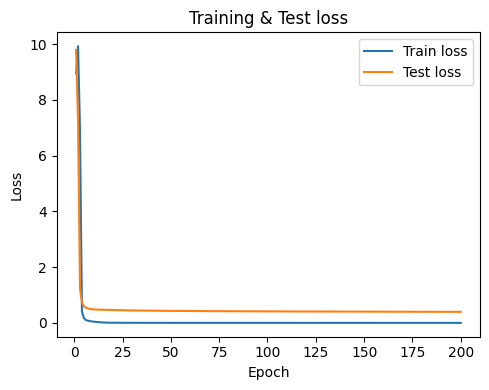

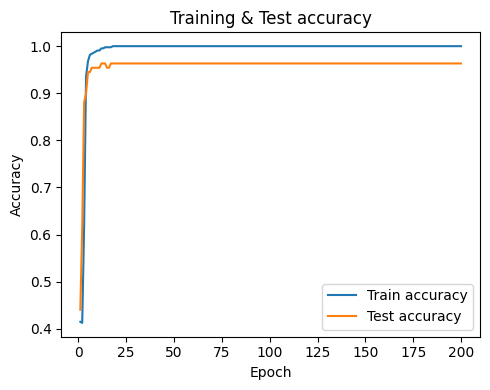

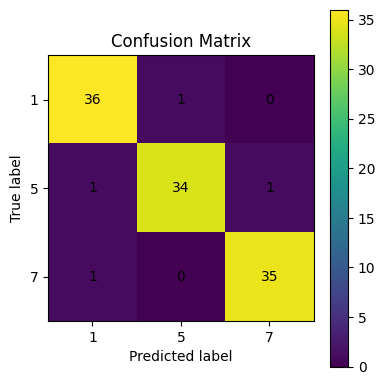

In [ ]:
# ---------- 主程序 / 画图和混淆矩阵 ----------

if __name__ == "__main__":
    # 直接在这里调用训练
    # 训练一个网络（比如用交叉熵）
    mlp, history = train_full_batch(
        X_train, y_train,
        X_test, y_test,
        n_epochs=200,
        lr=0.1,
        loss_type="ce",
        seed=0
    )

    # ---- 画 loss 曲线 ----
    epochs = np.arange(1, len(history["train_losses"]) + 1)

    plt.figure(figsize=(5, 4))
    plt.plot(epochs, history["train_losses"], label="Train loss")
    plt.plot(epochs, history["test_losses"], label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Test loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 画 accuracy 曲线----
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, history["train_accs"], label="Train accuracy")
    plt.plot(epochs, history["test_accs"], label="Test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Test accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Confusion Matrix ----
    y_pred_test = mlp.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_test)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, [1, 5, 7])  # 原始类名
    plt.yticks(tick_marks, [1, 5, 7])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    for i in range(3):
        for j in range(3):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()
